# Train image classifier with Huggingface

In [ ]:
from plancraft.train.train_fast_rcnn import sample_environment
for batch in sample_environment(batch_size=32, N=100):
    break

In [2]:
images, targets, raw_images, inv = batch

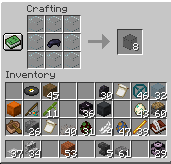

In [3]:
from PIL import Image
import numpy as np

img = Image.fromarray((images[0].cpu().numpy()*255).astype(np.uint8).transpose(1, 2, 0))
img.show()

In [4]:
import torch
# save images
torch.save(images, 'images.pth')

In [2]:
import torch
from plancraft.models.bbox_model import IntegratedBoundingBoxModel
import numpy as np
from PIL import Image

model = IntegratedBoundingBoxModel.from_pretrained("gautierdag/plancraft-maskrcnn")
model.eval()
model = model.cuda()

images = torch.load("images.pth")

raw_images = (images.cpu().numpy().transpose(0, 2, 3, 1) * 255).astype(np.uint8)
with torch.no_grad():
    images = images.cuda()
    predictions = model(images)

/tmp/ipykernel_754360/749736338.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  images = torch.load("images.pth")


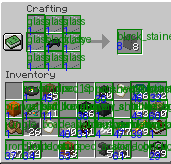

In [3]:
from minerl.herobraine.hero.mc import ALL_ITEMS
from PIL import Image, ImageDraw

for img_idx in range(len(images)):
    # generate image and target for validation
    img = Image.fromarray(raw_images[img_idx].copy())
    # for box in targets[img_idx]["boxes"]:
        # draw = ImageDraw.Draw(img)

    for box_idx in range(len(predictions[img_idx]["boxes"])):
        box = predictions[img_idx]["boxes"][box_idx]
        score = predictions[img_idx]["scores"][box_idx]
        label = predictions[img_idx]["labels"][box_idx]
        quantity = predictions[img_idx]["quantities"][box_idx]

        if score > 0.5:
            draw = ImageDraw.Draw(img)
            draw.rectangle(box.cpu().tolist(), outline="green")
            label_name = ALL_ITEMS[label.item()]
            draw.text(
                (box[0], box[1]),
                f"{label_name}",
                fill="green",
            )
            draw.text(
                (box[0], box[1] + 10),
                f"{quantity.item()}",
                fill="blue",
            )

    img.show()
    break

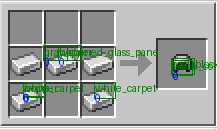

In [3]:
armor_image = Image.open("armor_recipe.png").convert("RGB")
# to tensor
import torchvision.transforms.v2 as v2
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
armor_image_tensor = transform(armor_image).cuda()

with torch.no_grad():
    armor_image_tensor = armor_image_tensor.unsqueeze(0)
    predictions = model(armor_image_tensor)

for box_idx in range(len(predictions[0]["boxes"])):
    box = predictions[0]["boxes"][box_idx]
    score = predictions[0]["scores"][box_idx]
    label = predictions[0]["labels"][box_idx]
    quantity = predictions[0]["quantities"][box_idx]

    if score > 0.05:
        draw = ImageDraw.Draw(armor_image)
        draw.rectangle(box.cpu().tolist(), outline="green")
        label_name = ALL_ITEMS[label.item()]
        draw.text(
            (box[0], box[1]),
            f"{label_name}",
            fill="green",
        )
        draw.text(
            (box[0], box[1] + 10),
            f"{quantity.item()}",
            fill="blue",
        )

armor_image.show()

### Multimodal Model

In [1]:
from train_oam import PlancraftDialogueDataset, PlancraftAOM, PlancraftAOMConfig, collate_fn

In [2]:
dataset = PlancraftDialogueDataset(use_images=True, split="val")

Loading dialogue dataset


In [3]:
model = PlancraftAOM(PlancraftAOMConfig())

Loading checkpoint shards: 100%|██████████| 4/4 [00:22<00:00,  5.53s/it]


In [4]:
batch = collate_fn([dataset[0]])
print(batch)

{'batch_messages': [[{'role': 'system', 'content': 'You are crafting in Minecraft. You need to decide on the next action.\n\nCrafting Grid: The crafting table is organized into a 3x3 grid. Each slot in the grid has a unique identifier:\n    - Top row: [A1] [A2] [A3]\n    - Middle row: [B1] [B2] [B3]\n    - Bottom row: [C1] [C2] [C3]\n\nThe output of the crafting process is placed in a designated output slot labeled [0] You cannot move or smelt items directly into slot [0]\n\nInventory Slots: The remaining inventory slots (outside of the crafting grid) are used for storing items. These slots are labeled as [I1] to [I36]\n\nActions:\n\t- move: Transfer a specific quantity of an item from one slot to another\n\t- smelt: Smelt an item in a furnace and moves the output to a specific slot\n\nFormat\n\t- `move: from [Source] to [Target] with quantity N`\n\t- `smelt: from [Source] to [Target] with quantity N`\n\nExample:\n    - `move: from [I2] to [A1] with quantity 3`\n    - `smelt: from [I5]

In [5]:
model(**batch)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


CausalLMOutputWithPast(loss=tensor(1.4380, device='cuda:0', grad_fn=<ToCopyBackward0>), logits=tensor([[[-2.9511,  1.5943,  7.4130,  ...,  1.6402,  1.6402, -4.5635],
         [-4.5963, -4.6851, -7.7461,  ...,  4.6581,  4.6580,  1.0647],
         [-6.8954, -1.7458, -1.5412,  ...,  4.3758,  4.3754, -1.7495],
         ...,
         [ 1.3284, -1.8745,  1.7251,  ...,  2.1045,  2.1045,  2.1551],
         [ 3.5794,  6.4975,  4.9519,  ...,  0.4357,  0.4358,  4.5722],
         [-0.9883,  2.8604, -0.9068,  ...,  4.6536,  4.6533,  0.5204]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>), past_key_values=((tensor([[[[ 5.5868e-01,  9.8483e-01,  1.0634e+00,  ...,  1.3285e+00,
           -9.2118e-02,  4.1570e-01],
          [ 1.1673e-01, -1.4595e-01, -2.1422e-02,  ...,  4.4308e-02,
           -1.1752e-01, -1.4955e-01],
          [-6.1431e+00, -3.1998e+00, -1.6797e+00,  ...,  2.1615e-01,
           -1.6038e+00, -1.5500e+00],
          ...,
          [-1.9031e+00,  2.7397e+00,  1.4681e+00,  ..., -

In [7]:
import wandb
from peft import LoraConfig, get_peft_model
from transformers import (
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)

lora_alpha: int = 16
lora_dropout: float = 0.1
lora_r: int = 64
batch_size = 1
num_train_epochs = 1
gradient_accumulation_steps = 4
max_grad_norm: float = 0.3
warmup_ratio: float = 0.03
num_train_epochs: int = 3
num_workers: int = 1
learning_rate: float = 5e-5
name = "plancraftoam"

target_modules = [
    "q_proj",
    "v_proj",
    "k_proj",
]

lora_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    target_modules=target_modules,
    init_lora_weights="gaussian",
    bias="none",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "embed_tokens",
        "lm_head",
        "vision_to_text_embedding",
    ],  # train and save embeddings/output layer
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 1,092,628,480 || all params: 9,175,410,848 || trainable%: 11.9082


In [16]:
import wandb

name = "test-plancraft-aom"
wandb.init(
    project="plancraft-train",
    entity="itl",
    mode="online",
    name=name,
)

training_args = TrainingArguments(
    output_dir=f"outputs/{name}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    gradient_accumulation_steps=gradient_accumulation_steps,
    max_grad_norm=max_grad_norm,
    learning_rate=learning_rate,
    optim="adamw_hf",
    lr_scheduler_type="cosine",
    warmup_ratio=warmup_ratio,
    dataloader_num_workers=num_workers,
    dataloader_pin_memory=True,
    logging_dir=f"outputs/logs/{name}",
    logging_steps=1,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    gradient_checkpointing=False,
    bf16=True if torch.cuda.is_bf16_supported() else False,  # bf16 support check
    report_to="wandb",
)


# Initialize the Huggingface Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(e

TypeError: Caught TypeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/parallel_apply.py", line 83, in _worker
    output = module(*input, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/peft/peft_model.py", line 1577, in forward
    return self.base_model(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/peft/tuners/tuners_utils.py", line 188, in forward
    return self.model.forward(*args, **kwargs)
TypeError: PlancraftAOM.forward() got an unexpected keyword argument 'input_ids'


In [8]:
model.generate(
    
    do_sample=True,
    temperature=temperature,
    max_new_tokens=max_tokens,
    pad_token_id=self.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    past_key_values=past_key_values,
    return_legacy_cache=True,
)


NameError: name 'model' is not defined

Help on method generate in module transformers.generation.utils:

generate(inputs: Optional[torch.Tensor] = None, generation_config: Optional[transformers.generation.configuration_utils.GenerationConfig] = None, logits_processor: Optional[transformers.generation.logits_process.LogitsProcessorList] = None, stopping_criteria: Optional[transformers.generation.stopping_criteria.StoppingCriteriaList] = None, prefix_allowed_tokens_fn: Optional[Callable[[int, torch.Tensor], List[int]]] = None, synced_gpus: Optional[bool] = None, assistant_model: Optional[ForwardRef('PreTrainedModel')] = None, streamer: Optional[ForwardRef('BaseStreamer')] = None, negative_prompt_ids: Optional[torch.Tensor] = None, negative_prompt_attention_mask: Optional[torch.Tensor] = None, **kwargs) -> Union[transformers.generation.utils.GenerateDecoderOnlyOutput, transformers.generation.utils.GenerateEncoderDecoderOutput, transformers.generation.utils.GenerateBeamDecoderOnlyOutput, transformers.generation.utils.GenerateBe

In [9]:
from transformers import Idefics2ForConditionalGeneration

CausalLMOutputWithPast(loss=tensor(1.3157, device='cuda:0', grad_fn=<ToCopyBackward0>), logits=tensor([[[-2.9511,  1.5943,  7.4130,  ...,  1.6402,  1.6402, -2.2110],
         [-4.5962, -4.6851, -7.7461,  ...,  4.6581,  4.6580, -3.6556],
         [-6.8953, -1.7458, -1.5411,  ...,  4.3758,  4.3754, -2.5226],
         ...,
         [ 1.7377, -4.9300,  1.5873,  ..., -1.4772, -1.4773,  0.5905],
         [ 1.3927,  3.8085,  0.9183,  ...,  1.4137,  1.4137,  0.1045],
         [ 1.3488,  4.2648,  2.1989,  ...,  3.5641,  3.5640, -4.2275]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>), past_key_values=((tensor([[[[ 5.5868e-01,  9.8483e-01,  1.0634e+00,  ...,  1.3285e+00,
           -9.2118e-02,  4.1570e-01],
          [ 1.1673e-01, -1.4595e-01, -2.1422e-02,  ...,  4.4308e-02,
           -1.1752e-01, -1.4955e-01],
          [-6.1431e+00, -3.1998e+00, -1.6797e+00,  ...,  2.1615e-01,
           -1.6038e+00, -1.5500e+00],
          ...,
          [ 1.5915e+00, -6.9595e-01, -3.8946e-01,  ..., -

In [38]:
# from transformers import LlamaForCausalLM

# help(LlamaForCausalLM.forward)
# for i in model.text_model.named_parameters():
    # if "1" in f"{i[1].device}":
    # print(f"{i[1].device}")

# !pip install --upgrade transformers


In [10]:
total_boxes


258

In [4]:
model.load_adapter("gautierdag/oa-llama3-r64-a32")

Loading adapter weights from gautierdag/oa-llama3-r64-a32 led to unexpected keys not found in the model:  ['model.embed_tokens.modules_to_save.default.modules_to_save.weight', 'model.embed_tokens.modules_to_save.default.original_module.weight', 'lm_head.modules_to_save.default.modules_to_save.weight', 'lm_head.modules_to_save.default.original_module.weight']. 


In [13]:
from plancraft.models.prompts import get_prompt_example

example = get_prompt_example(actions=["move", "smelt"])

messages= tokenizer.apply_chat_template(
    [example],
    add_generation_prompt=True,
    tokenize=False,
)

In [17]:
inputs = tokenizer.encode(messages[0], return_tensors="pt")